In [1]:
from util import load_macros
load_macros("macros.tex")

$\newcommand{\C}{\mathbb{C}}$
$\newcommand{\Du}{\underline{D}}$
$\newcommand{\veps}{\varepsilon}$
$\newcommand{\eps}{\epsilon}$
$\newcommand{\f}{\textbf{f}}$
$\newcommand{\fb}{\textbf{f}}$
$\newcommand{\F}{\mathbb{F}}$
$\newcommand{\Fb}{\textbf{F}}$
$\newcommand{\gb}{\textbf{g}}$
$\newcommand{\h}{\textbf{h}}$
$\newcommand{\kb}{\textbf{k}}$
$\newcommand{\M}{\mathcal{M}}$
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\Norm}{\textbf{N}}$
$\newcommand{\n}{\textbf{n}}$
$\newcommand{\vp}{\varphi}$
$\newcommand{\vph}{\hat{\varphi}}$
$\newcommand{\p}{\phi}$
$\newcommand{\Proj}{\mathbb{P}}$
$\newcommand{\Pcal}{\mathcal{P}}$
$\newcommand{\Q}{\mathbb{Q}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\rb}{\textbf{r}}$
$\newcommand{\s}[1]{\mathcal{#1}}$
$\newcommand{\supp}{\text{supp}}$
$\newcommand{\Surf}{\textbf{S}}$
$\newcommand{\tpsi}{\tilde{\psi}}$
$\newcommand{\ub}{\textbf{u}}$
$\newcommand{\U}{\textbf{U}}$
$\newcommand{\vb}{\textbf{v}}$
$\newcommand{\V}{\mathbb{V}}$
$\newcommand{\wb}{\textbf{w}}$
$\newcommand{\x}{\textbf{x}}$
$\newcommand{\xh}{\hat{x}}$
$\newcommand{\X}{\textbf{X}}$
$\newcommand{\y}{\textbf{y}}$
$\newcommand{\yh}{\hat{y}}$
$\newcommand{\Y}{\textbf{Y}}$
$\newcommand{\Z}{\mathbb{Z}}$
$\DeclareMathOperator{\sech}{sech}$
$\DeclareMathOperator{\atanh}{atanh}$
$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\tr}{Trace}$
$\DeclareMathOperator{\gradsymm}{\nabla_{s}}$
$\DeclareMathOperator{\divergence}{div}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator*{\argmin}{argmin}$
$\DeclareMathOperator*{\argmax}{argmax}$
$\DeclareMathOperator{\Span}{Span}$
$\DeclareMathOperator{\rank}{rank}$
$\newcommand{\br}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\paren}[1]{\left(#1\right)}$
$\newcommand{\sq}[1]{\left[#1\right]}$
$\newcommand{\set}[1]{\left\{\: #1 \:\right\}}$
$\newcommand{\setp}[2]{\left\{\, #1\: \middle|\: #2 \, \right\}}$
$\newcommand{\abs}[1]{\left| #1 \right|}$
$\newcommand{\norm}[1]{\left\| #1 \right\|}$
$\newcommand{\system}[1]{\left\{ \begin{array}{rl} #1 \end{array} \right.}$
$\newcommand{\pf}[2]{\frac{\partial #1}{\partial #2}}$
$\newcommand{\ipt}[2]{\langle #1,#2 \rangle}$
$\newcommand{\ip}{\int_{-\infty}^{+\infty}}$
$\renewcommand{\ker}[1]{\mathcal{N}(#1)}$
$\newcommand{\ran}[1]{\mathcal{R}(#1)}$
Loaded macros


Solve the 1D Navier-Stokes equation on a square domain.  That is, find $p,\mathbf{v}:\Omega \rightarrow \R \times \R^n$ such that

$$
\begin{align*}
\nabla \cdot \mathbf{v}  &= r(x,t) \\
\frac{\partial (\rho\mathbf{v})}{\partial t} + \nabla\cdot\left(\rho\mathbf{v}\otimes\mathbf{v}\right) +  \nabla p  - \nabla \cdot \left(\mu \nabla\mathbf{v}\right) &= \rho\mathbf{f}(x,t)
\end{align*}
$$
on 
$$
\Omega = [0,1]
$$
 where $r(x,t)$ is a function of space and time only, $\mathbf{f}(x,t)$ and the density, $\rho$, and viscosity, $\mu$, are constant. 
 
To be complete and solvable we add in dirichlet boundary conditions on $p(x,t)$ and inflow boundary conditions on velocity $v(x,t)$,  (this means we must set the diffusive bc = 0 and advective bc = None to allow for the inflow bc to happen)
$$
\left.p\right|_{\partial\Omega} = p(x,t)
$$
and for $\partial\Omega^{in} = \{ x \:|\: v(x,t)\cdot n < 0\}$ we have inflow in which case we set
$$
\left.v\right|_{\partial\Omega^{in}} = v(x,t). 
$$
Finally we need initial conditions
$$
u(x,t=0) = u_0(x), \hspace{1cm} p(x,t=0) = p_0(x).
$$

In [2]:
from proteus.iproteus import * #pull in what we need for using proteus interactively
Profiling.logLevel=2
Profiling.verbose = True

Define the PDE by defining the coefficients

In [3]:
class NavierStokes1D(TransportCoefficients.TC_base):
    """
    The coefficients of the Poisson equation 
    """
    def __init__(self,rofx,fofx,rho=1.0,mu=1.0):
        TransportCoefficients.TC_base.__init__(self, 
                         nc=2, #number of components
                         variableNames=['p','v'],
                         mass = {1:{1:'linear'}}, # du/dt
                         advection = {0:{1:'linear'}, # \nabla\cdot v
                                      1:{1:'nonlinear'}}, # \nabla \cdot (v\otimes v)
                         hamiltonian = {1:{0:'linear'}}, # grad (p)
                         diffusion = {1:{1:{1:'constant'}}}, # - 1/Re * \grad v
                         potential = {1:{1:'u'}}, # define the potential for the diffusion term to be the solution itself
                         reaction  = {0:{0:'constant'}, # r(x)
                                      1:{1:'constant'}}) # f(x)
        self.rofx=rofx
        self.fofx=fofx
        self.rho=rho
        self.mu=mu
        
    def evaluate(self,t,c):
        """
        evaluate quadrature point values held in the dictionary c
        These are labelled according to the 'master equation.' For example,
         
        c[('a',0,0)] = diffusion coefficient for the 0th equation (first) with respect to the
                       0th potential (the solution itself)
                       The value at each quadrature point is a n_d x n_d tensor (n_d=number of space dimensions).
                       Usually the tensor values are stored as a flat array in compressed sparse row format to save space. 
                       By default, we assume the tensor is full though.
                       
        c[('r',0)]   = reaction term for the 0th equation. This is where we will put the source term
        """
        p = c[('u',0)]
        v = c[('u',1)] #1D - x component of velocity
        grad_p = c[('grad(u)',0)]
        #equation 0  div(f) + r = 0  (proteus  notation)  div(velocity)=r(x) (our notation)
        c[('f',0)][...,0] = v
        c[('df',0,1)][...,0] = 1.0  # d_f^0_d_u^0
        c[('r',0)][:]     = -self.rofx(c['x'][:],t)
        c[('dr',0,0)][:]   = 0.0
        #equation 1   u_t + div (u^2) + grad(p) + div(-1/Re grad(v)) + f = 0
        c[('m',1)][:] = rho*v  # d/dt ( rho * v) = d/dt (m_1)
        c[('dm',1,1)][:] = rho  # d_m^1_d_u^1
        c[('f',1)][...,0] = rho*v*v # div ( v\otimes v)
        c[('df',1,1)][...,0] = 2.0*rho*v # d_f^1_d_u^1
        c[('H',1)][:] = grad_p[...,0] #grad(p)
        c[('dH',1,0)][...,0] = 1.0 # 1
        c[('r',1)][:]     = -rho*self.fofx(c['x'][:],t)
        c[('dr',1,1)][:]  = 0.0#0
        c[('a',1,1)][...,0] = mu # -mu*\grad v
        c[('da',1,1,1)][...,0] = 0.0 # -d_(1/Re)




Setup the problem by method of manufactured solution.

We will introduce a specific example that we have implemented, but we use sympy to symbolically compute the source terms based on the navier stokes equation as defined above.  In order to change the solution, it is only necessary to update p and v below.

A specific solution to 1D navier-stokes equation:

$$
p(x,t) = 1 + \sin(2\pi (x-t))
$$
and
$$
v(x,t) = \sin(2\pi(x-t))\cos(2\pi(x-t))
$$
thus
$$
r(x,t) = \nabla\cdot v = 2\pi\cos(4\pi(x-t))
$$
and
$$
\begin{split}
f(x,t) = -2\pi\cos(4\pi(x-t)) &+ 4\pi\sin(2\pi(x-t))\cos^3(2\pi(x-t)) - 4\pi\sin^{3}(2\pi(x-t))\cos(2\pi(x-t))\\& + \frac{2\pi}{\rho}\cos(2\pi(x-t)) + \frac{8\pi^2\mu}{\rho}\sin(4\pi(x-t))
\end{split}
$$

Note that we are not divergence free here in 1D since that would require constant velocity.  The momentum equation must be written in the form  $\nabla\cdot(v\otimes v)$  instead of $v\cdot\nabla v$ since the second form utilizes the fact that $v$ is divergence free.

Define the python functions for evaluating the terms. Note that the x array for the quadrature points will be a multidimensional array. The last dimension will be 3 always though.  This is done using the sympy module and is easily modified to represent any manufactured solution desired.

In [4]:
#use numpy for evaluations
import numpy as np

# Reynolds number
rho = 1.0
mu = 1.0

# Create the manufactured solution and run through sympy 
# to create the forcing function and solutions etc
#
# Import specific sympy functions to avoid overloading 
# numpy etc functions
from sympy.utilities.lambdify import lambdify
from sympy import (symbols, 
                   simplify,
                   diff)
from sympy.functions import (sin as sy_sin,
                             cos as sy_cos)
from sympy import pi as sy_pi

# use xs and ts to represent symbolic x and t
xs,ts = symbols('x t')
# solution:
p = 1 + sy_sin(2*sy_pi*(xs-ts))
v = sy_sin(2*sy_pi*(xs-ts))*sy_cos(2*sy_pi*(xs-ts))

# manufacture the source terms:
r = simplify(diff(v,xs))
# note that we use the div(rho u\otimes u) form of convection since we are not
# divergence free
f = simplify((diff(rho*v,ts) + diff(rho*v*v,xs) + diff(p,xs) - diff(mu*v,xs,xs))/rho)

# use lambdify to convert from sympy to python expressions
pl = lambdify((xs, ts), p, "numpy")
vl = lambdify((xs, ts), v, "numpy")
rl = lambdify((xs, ts), r, "numpy")
fl = lambdify((xs, ts), f, "numpy")

# convert python expressions to the format we need for multidimensional x values
def pex0(x,t): 
    return pl(x[...,0],t)

def vex0(x,t):
    return vl(x[...,0],t)

def rofx0(x,t):
    return rl(x[...,0],t)

def fofx0(x,t):
    return fl(x[...,0],t)


Define the physical input to the model

In [5]:
#use numpy for evaluations
import numpy as np
physics = default_p
physics.name = "navier_stokes_1d"
physics.nd = 1; #One dimension
#spatial domain
physics.L=(1.0,1.0,1.0)

# Integrate from t=0 to t=1
physics.T = 1.0

#the object for evaluating the coefficients   
physics.coefficients=NavierStokes1D(rofx0,fofx0,rho,mu)

#this functions job is to return another function holding the Dirichlet boundary conditions 
# wherever they are set
    
eps=1.0e-8
boundaryFlags = {'left':1,'right':2,'top':3}
def getDBC_p(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: pex0(x,t)
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: pex0(x,t)
    else:
        return None
    
def getDBC_v(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: vex0(x,t)
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: vex0(x,t)
    else:
        return None
    
def getNone(x,flag):
    return None

def getZeroFlux(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: 0.0
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: 0.0
    else:
        return None
    
class getIBC_p:
    def __init__(self):
        self.pex0=pex0
        pass
    def uOfXT(self,x,t):
        return self.pex0(x,t)

    
class getIBC_v:
    def __init__(self):
        self.vex0=vex0
        pass
    def uOfXT(self,x,t):
        return self.vex0(x,t)
    
physics.initialConditions = {0:getIBC_p(),
                             1:getIBC_v()}

physics.dirichletConditions = {0:getDBC_p,#pressure Dirichlet
                               1:getDBC_v}

physics.advectiveFluxBoundaryConditions = {0:getNone}#dummy condition for non-existent  advective flux
#physics.advectiveFluxBoundaryConditions = {1:getZeroFlux}#dummy condition for non-existent  advective flux

#there are no diffusion terms in this model, but I had to 
physics.diffusiveFluxBoundaryConditions = {1:{1:getZeroFlux}}#viscous flux
physics.fluxBoundaryConditions = {0:'mixedFlow',1:'outFlow'}
#physics.fluxBoundaryConditions = {0:'setFlow',1:'setFlow'}

Define the numerics input for the problem

In [6]:
numerics=default_n
#piecewise linears
numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis,#pressure space
                      1:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}#velocity space

numerics.timeIntegration = TimeIntegration.BackwardEuler
numerics.DT = 0.01
numerics.tnList = list(np.arange(0.0,physics.T+numerics.DT,numerics.DT))
# numerics.nDTout=10

#Quadrature rules for elements and element  boundaries
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,5)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,5)
#number of nodes in the x and y direction
numerics.nn = 101
#numerics.nny= 41
#matrix type
numerics.numericalFluxType = NumericalFlux.StrongDirichletFactory(physics.fluxBoundaryConditions)
#numerics.numericalFluxType = MixedDarcy_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_IIPG_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_Diagonal_average
numerics.matrix = LinearAlgebraTools.SparseMatrix
#use petsc solvers wrapped by petsc4py
#numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
#numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
#using petsc4py requires weak boundary condition enforcement
#can also use our internal wrapper for SuperLU
numerics.multilevelLinearSolver = LinearSolvers.LU
numerics.levelLinearSolver = LinearSolvers.LU

numerics.multilevelNonlinearSolver = NonlinearSolvers.Newton
numerics.levelNonlinearSolver = NonlinearSolvers.Newton

#linear solve rtolerance

numerics.linTolFac = 0.001
numerics.tolFac = 0.0

numerics.l_atol_res = 1.0e-5
numerics.nl_atol_res = 1.0e-5
numerics.periodicDirichletConditions=None
#
# split operator options (trivial since we're not splitting)
#
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = numerics.tnList

Construct a NumericalSolution object and solve the problem

In [7]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')


# begin error analysis and plotting of solution

#arrays for using matplotlib's unstructured plotting interface
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
#y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
#triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray

# grab the last time step solution and save the components as pT and vT
pT = ns.modelList[0].levelModelList[-1].u[0].dof
vT = ns.modelList[0].levelModelList[-1].u[1].dof



[      26] Initializing NumericalSolution for navier_stokes_1d
 System includes: 
navier_stokes_1d

[      26] Setting Archiver(s)
[      26] Setting up MultilevelMesh
[      26] Building one multilevel mesh for all models
[      26] Generating mesh for navier_stokes_1d
[      26] Partitioning mesh among 1 processors using partitioningType = 0
[      26] Number of Subdomain Elements Owned= 100
[      26] Number of Subdomain Elements = 100
[      26] Number of Subdomain Nodes Owned= 101
[      26] Number of Subdomain Nodes = 101
[      26] Number of Subdomain elementBoundaries Owned= 101
[      26] Number of Subdomain elementBoundaries = 101
[      26] Number of Subdomain Edges Owned= 100
[      26] Number of Subdomain Edges = 100
[      26] Finished partitioning
[      26] *** Global ***
Number of edges : 100
Number of nodes : 101

*** Local ***
Number of edges : 100
Number of nodes : 101

[      26] Numerical Solution Sparse diffusion information key (1, 1) = (array([0, 1], dtype=int3

Plot the solution with matplotlib. Only works for $C^0 P^1$ right now

In [8]:
%matplotlib inline

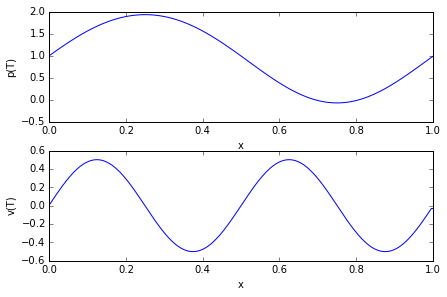

In [9]:
# plot computed solutions

import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(2,1)
fig.tight_layout() # spread out the plots so that they don't overlap
ax1.plot(x,pT)
ax1.set_xlabel('x')
ax1.set_ylabel('p(T)')
useTH=True
if not useTH:
    ax2.plot(x,vT[:numerics.nn])
    ax2.set_xlabel('x')
    ax2.set_ylabel('v(T)')
else:
    xm = np.array(0.5*(x[:-1]+x[1:]))
    xq=[];
    vq=[];
    pq=[];
    for i in range(numerics.nn-1):
        xq.append(x[i])
        vq.append(vT[i])
#    uq.append(u[i])
        xq.append(xm[i])
        vq.append(vT[numerics.nn+i])
#    uq.append(u[numerics.nn+i])
    xq.append(x[-1])
    vq.append(vT[-1])
#uq.append(u[-1])
#xq = np.concatenate([x,xm])
#xq.append(x1[-1])
#ax1.plot(xq,uq)
    ax2.plot(xq,vq)
    ax2.set_xlabel('x')
    ax2.set_ylabel('v(T)')

In [10]:
# extract exact solutions
import numpy as np
pex_vals_at_T = pex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray,physics.T)
vex_vals_at_T = vex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray,physics.T)
rex_vals_at_T = rofx0(ns.modelList[0].levelModelList[-1].mesh.nodeArray,physics.T)

Compare to the exact solution, evaluated at the degrees of freedom. Again, only works for $C^0 P^1$ elements

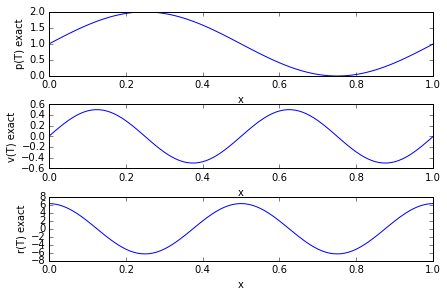

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig.tight_layout() # spread out the plots so that they don't overlap
ax1.plot(x,pex_vals_at_T)
ax1.set_xlabel('x')
ax1.set_ylabel('p(T) exact') 
ax2.plot(x,vex_vals_at_T)
ax2.set_xlabel('x')
ax2.set_ylabel('v(T) exact')
ax3.plot(x,rex_vals_at_T)
ax3.set_xlabel('x')
ax3.set_ylabel('r(T) exact')

(101,) (100,)
maximal error of pressure on gridpoints             = 0.0631607853313
Trapezoidal rule approx to \ell_2 error of pressure = 0.0382973545235

maximal error of velocity on gridpoints                        is 8.14329391696e-08
Trapezoidal rule approx to \ell_2 error of velocity for nn=101 is 4.98119736239e-08


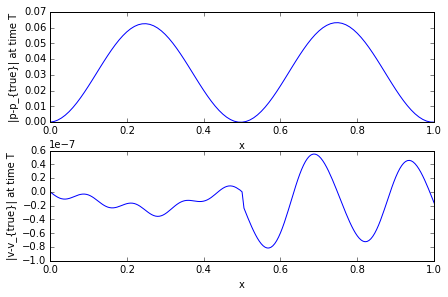

In [12]:
print x.shape,xm.shape

# output error data for pressure
fig, (ax1,ax2) = plt.subplots(2,1)
fig.tight_layout() # spread out the plots so that they don't overlap
err_p = pT-pex_vals_at_T
print "maximal error of pressure on gridpoints             = %s" % max(abs(err_p))
ax1.plot(x,abs(err_p))
ax1.set_xlabel('x')
ax1.set_ylabel('|p-p_{true}| at time T')
err_p *= err_p
err_p *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_p = np.sqrt(err_p.sum())

print "Trapezoidal rule approx to \ell_2 error of pressure = %s\n" % L2approx_p


# output error data for velocity
vtrue = 0.0*vT
for i,val in enumerate(np.concatenate((x,xm))):
    vtrue[i] = vex0(np.array([val]),physics.T)
err_v = vT-vtrue
print "maximal error of velocity on gridpoints                        is %s" % max(abs(err_v))
ax2.plot(xq,err_v)
ax2.set_xlabel('x')
ax2.set_ylabel('|v-v_{true}| at time T')
err_v *= err_v
err_v *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_v = np.sqrt(err_v.sum())
print "Trapezoidal rule approx to \ell_2 error of velocity for nn=%s is %s" % (numerics.nn, L2approx_v)
